# Installing software for this notebook
See: https://github.com/broadinstitute/Drop-seq/tree/master/src/python to directions on how to install the python code this notebook depends on.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
from typing import Optional, Tuple
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib.backends.backend_pdf import PdfPages
from typing import Optional, Dict, List


# Reusable functions

In [2]:
def validate_save_path(save):
    if save is not None:
        if not isinstance(save, str):
            raise ValueError(f"`save` must be None or str, got {type(save)}")
        save_dir = os.path.dirname(save) or "."
        if not os.path.isdir(save_dir):
            raise ValueError(f"Directory does not exist or is not writable: {save_dir}")
        if not os.access(save_dir, os.W_OK):
            raise PermissionError(f"Directory is not writable: {save_dir}")

In [3]:
def parse_matrix_input(in_file: str) -> ad.AnnData:
    gene_scores_merged = pd.read_csv(in_file, sep='\t').transpose()
    # make an anndata object out of dataframe to take advantage of scanpy functions
    adata = ad.AnnData(gene_scores_merged)
    adata.obs['celltype'] = adata.obs_names.astype('category') # adding cell type label to obs
    return adata

In [4]:
def order_celltypes(
    adata: ad.AnnData,
    num_pcs: int = 10,
    figsize: Tuple[float, float] = (10, 5),
    save: Optional[str] = None,
) -> tuple[ad.AnnData, plt.Figure]:
    """
    Run PCA, build dendrogram, plot heatmap, and reorder adata by dendrogram order.

    Parameters
    ----------
    adata : AnnData
        Input AnnData object.
    num_pcs : int
        Number of PCs to compute and use for dendrogram.
    figsize : tuple
        Figure size if Scanpy creates one.
    save : str or None
        If None, do not save.
        If str, must be a valid writable file path.

    Returns
    -------
    adata : AnnData
        Reordered AnnData object.
    fig : matplotlib.figure.Figure
        Figure object containing the heatmap.
    """
    # validate save parameter
    validate_save_path(save)

    sc.pp.pca(adata, n_comps=num_pcs)
    sc.tl.dendrogram(adata, groupby="celltype", n_pcs=num_pcs)

    out = sc.pl.heatmap(
        adata,
        var_names=adata.var_names,
        groupby="celltype",
        dendrogram=True,
        cmap="seismic",
        vcenter=0,
        figsize=figsize,
        show=False,
        show_gene_labels=False,
    )
    fig = out["heatmap_ax"].figure

    if save is not None:
        fig.savefig(save, dpi=300, bbox_inches="tight")

    celltype_order = adata.uns["dendrogram_celltype"]["categories_ordered"]
    adata = adata[celltype_order, :].copy()

    return adata, fig

In [5]:
def k_selection_plot(
    adata: ad.AnnData,
    k_range: tuple[int, int] = (2, 30),
    ax: Optional[plt.Axes] = None,
    figsize: Tuple[float, float] = (10, 5),
    save: Optional[str] = None,
) -> Tuple[plt.Axes, pd.DataFrame]:
    """
    Run K-means for a range of k values, compute silhouette scores and WCSS,
    plot them with a secondary Y-axis, and return the figure, axis, and a DataFrame.
    """
    # validate save parameter
    validate_save_path(save)

    if ax is None:
        with plt.ioff():
            fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure

    adata_tmp = adata.copy().transpose()
    ks = list(range(k_range[0], k_range[1] + 1))

    wcss = []
    silhouette_scores = []
    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=12, n_init=10).fit(adata_tmp.X)
        labels = kmeans.labels_
        silhouette_scores.append(silhouette_score(adata_tmp.X, labels))
        wcss.append(kmeans.inertia_)

    df = pd.DataFrame({
        "k": ks,
        "silhouette_score": silhouette_scores,
        "wcss": wcss,
    })

    # Use pandas plotting with secondary_y
    df.plot(
        x="k",
        y="silhouette_score",
        ax=ax,
        color="black",
        marker="o",
        linestyle="--",
        label="Silhouette Score",
    )
    df.plot(
        x="k",
        y="wcss",
        ax=ax,
        secondary_y=True,
        color="blue",
        marker="o",
        linestyle="--",
        label="WCSS",
    )

    # Customize labels
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel("Silhouette Score", color="black")
    ax.right_ax.set_ylabel("Within-Cluster Sum of Squares (WCSS)", color="blue")

    if save is not None:
        ax.figure.savefig(save, dpi=300)

    return ax, df


In [6]:
def plot_gene_clustering(adata: ad.AnnData,
                         k:int = 20,
                         figsize: Tuple[float, float] = (15, 9),
                         save: Optional[str] = None,
                         out_cluster_labels_filename: Optional[str] = None,):

    validate_save_path(save)

    adata_tmp = adata.copy().transpose()

    kmeans = KMeans(n_clusters=k, random_state=12, n_init=10).fit(adata_tmp.X)
    adata_tmp.obs['gene_clusters'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
    adata_tmp.obs['gene_clusters'] = adata_tmp.obs['gene_clusters'].astype("category")

    sc.tl.dendrogram(adata_tmp, groupby="gene_clusters",
                     cor_method="spearman", linkage_method="centroid",
                     use_rep="X")

    with plt.ioff():
        out = sc.pl.heatmap(
            adata_tmp,
            var_names=adata_tmp.var_names,
            groupby="gene_clusters",
            dendrogram=True,
            cmap="seismic",
            vcenter=0,
            swap_axes=True,
            figsize=figsize,
            show=False,
            show_gene_labels=True,
        )

    fig = out["heatmap_ax"].figure

    fig.text(
        0.03, 0.9, f"K={k}",
        ha="left", va="top",
        fontsize=20, fontweight="bold"
    )

    if save is not None:
        fig.savefig(save, dpi=300, bbox_inches="tight")

    if out_cluster_labels_filename is not None:
        adata_tmp.obs['gene_clusters'].to_csv(out_cluster_labels_filename)

    return fig


In [7]:
def make_base_paths(out_dir: str, prefix: str) -> dict[str, str]:
    """
    Generate output file paths for gene clustering that dont rely on K
    """
    return {
        "cell_ordering_heatmap": f'{out_dir}/{prefix}.celltype_order_heatmap.png',
        "k_selection_metrics": f'{out_dir}/{prefix}.k_selection_metrics.txt',
        "k_selection_plot": f'{out_dir}/{prefix}.k_selection_plot.png',
        "labels_matrix": os.path.join(out_dir, f"{prefix}.gene_cluster_labels_matrix.txt"),
        "out_pdf": f'{out_dir}/{prefix}.pdf',
    }


In [8]:
def make_cluster_paths (out_dir, prefix, k):
    """
    Generate output file paths for gene clustering results for a given K.
    """
    return {
        "heatmap": os.path.join(out_dir, f"{prefix}.KmeansClusteredGenes_k{k}.png"),
        "labels": os.path.join(out_dir, f"{prefix}.KmeansClusteredGenes_k{k}_labels.txt"),
    }


In [9]:
def _read_labels(path: str) -> pd.DataFrame:
    """Robust reader: expects 2 cols (gene, cluster)."""
    df=pd.read_csv(path, sep=",")
    df.columns = ["gene", "cluster"]
    return df

def _merge_label_files(label_paths: Dict[int, str], out_path: str, delete: bool = True) -> str:
    """Merge per-K label files into wide matrix [gene x K] and optionally delete inputs."""
    merged: Optional[pd.DataFrame] = None
    for K in sorted(label_paths.keys()):
        df = _read_labels(label_paths[K]).set_index("gene")
        df = df.rename(columns={"cluster": f"k{K}"})
        merged = df if merged is None else merged.join(df, how="outer")
    merged = merged.sort_index()
    merged.to_csv(out_path, sep="\t", index=True)
    if delete:
        for p in label_paths.values():
            try:
                os.remove(p)
            except OSError:
                pass
    return out_path

In [10]:
def run_gene_clustering_workflow(
    in_file: str,
    out_dir: str,
    prefix: str,
    k_range: Tuple[int, int] = (2, 30),
    num_pcs: int = 10,
    clust_k: Optional[int] = None,
    gene_cluster_figsize: Tuple[float, float] = (18, 12),
    cell_order_heatmap_size: Tuple[float, float] = (15, 10),
    k_selection_figsize: Tuple[float, float] = (8, 8),
    labels_matrix: Optional[str] = None,
    out_pdf: Optional[str] = None,
    print_pngs: bool = True,
    delete_label_files: bool = True,
) -> None:
    """
    End-to-end workflow:
      - parse input
      - order cell types and plot heatmap
      - K-selection plot + metrics TSV
      - gene clustering heatmap(s) + labels
      - merged labels file
      - optional multi-page PDF
    """
    if labels_matrix is not None:
        validate_save_path(labels_matrix)
    if out_pdf is not None:
        validate_save_path(out_pdf)

    adata = parse_matrix_input(in_file)
    base_paths = make_base_paths(out_dir, prefix)  # for metrics/plots

    figs: List[plt.Figure] = []
    label_paths: Dict[int, str] = {}

    # 1) Celltype ordering
    adata, fig1 = order_celltypes(
        adata,
        num_pcs=num_pcs,
        figsize=cell_order_heatmap_size,
        save=(base_paths["cell_ordering_heatmap"] if print_pngs else None),
    )
    figs.append(fig1)

    # 2) K-selection
    ax2, df = k_selection_plot(adata, k_range=k_range, figsize=k_selection_figsize)
    fig2 = ax2.figure
    figs.append(fig2)
    if print_pngs:
        fig2.savefig(base_paths["k_selection_plot"], dpi=300, bbox_inches="tight")
    df.to_csv(base_paths["k_selection_metrics"], sep="\t", index=False)

    # 3) Gene clustering
    def _run_gene_clust(K: int):
        clust_paths = make_cluster_paths(out_dir, prefix, K)
        fig = plot_gene_clustering(
            adata,
            k=K,
            figsize=gene_cluster_figsize,
            save=(clust_paths["heatmap"] if print_pngs else None),
            out_cluster_labels_filename=clust_paths["labels"],
        )
        figs.append(fig)
        label_paths[K] = clust_paths["labels"]

    if clust_k is None:
        for K in range(k_range[0], k_range[1] + 1):
            _run_gene_clust(K)
    else:
        _run_gene_clust(clust_k)

    # 4) Merge labels into matrix
    if labels_matrix is not None:
        _merge_label_files(label_paths, labels_matrix, delete=delete_label_files)

    # 5) Optional combined PDF
    if out_pdf is not None:
        with PdfPages(out_pdf) as pdf:
            for f in figs:
                pdf.savefig(f, bbox_inches="tight")

    for f in figs:
        plt.close(f)

# Parameters

In [11]:
sc.settings.set_figure_params(dpi=100)

# Input is a matrix with one row per gene, and one column for each condition.

in_file='/broad/bican_um1_mccarroll/RNAseq/analysis/CAP_freeze_2_analysis/differential_expression/differential_expression/cell_type_results_sex_age_region_interaction_absolute_effects/aggregated_results/age_DE_logFC_uncorrected_matrix.txt'
out_dir='/downloads/effect_size_clustering_results'
prefix="age_DE_logFC_uncorrected"

In [12]:
# Derived parameters
paths=make_base_paths(out_dir, prefix)
out_cell_ordering_heatmap_file=paths['cell_ordering_heatmap']
out_k_selection_metrics_file=paths['k_selection_metrics']
out_k_selection_plot_file=paths['k_selection_plot']

# Analysis

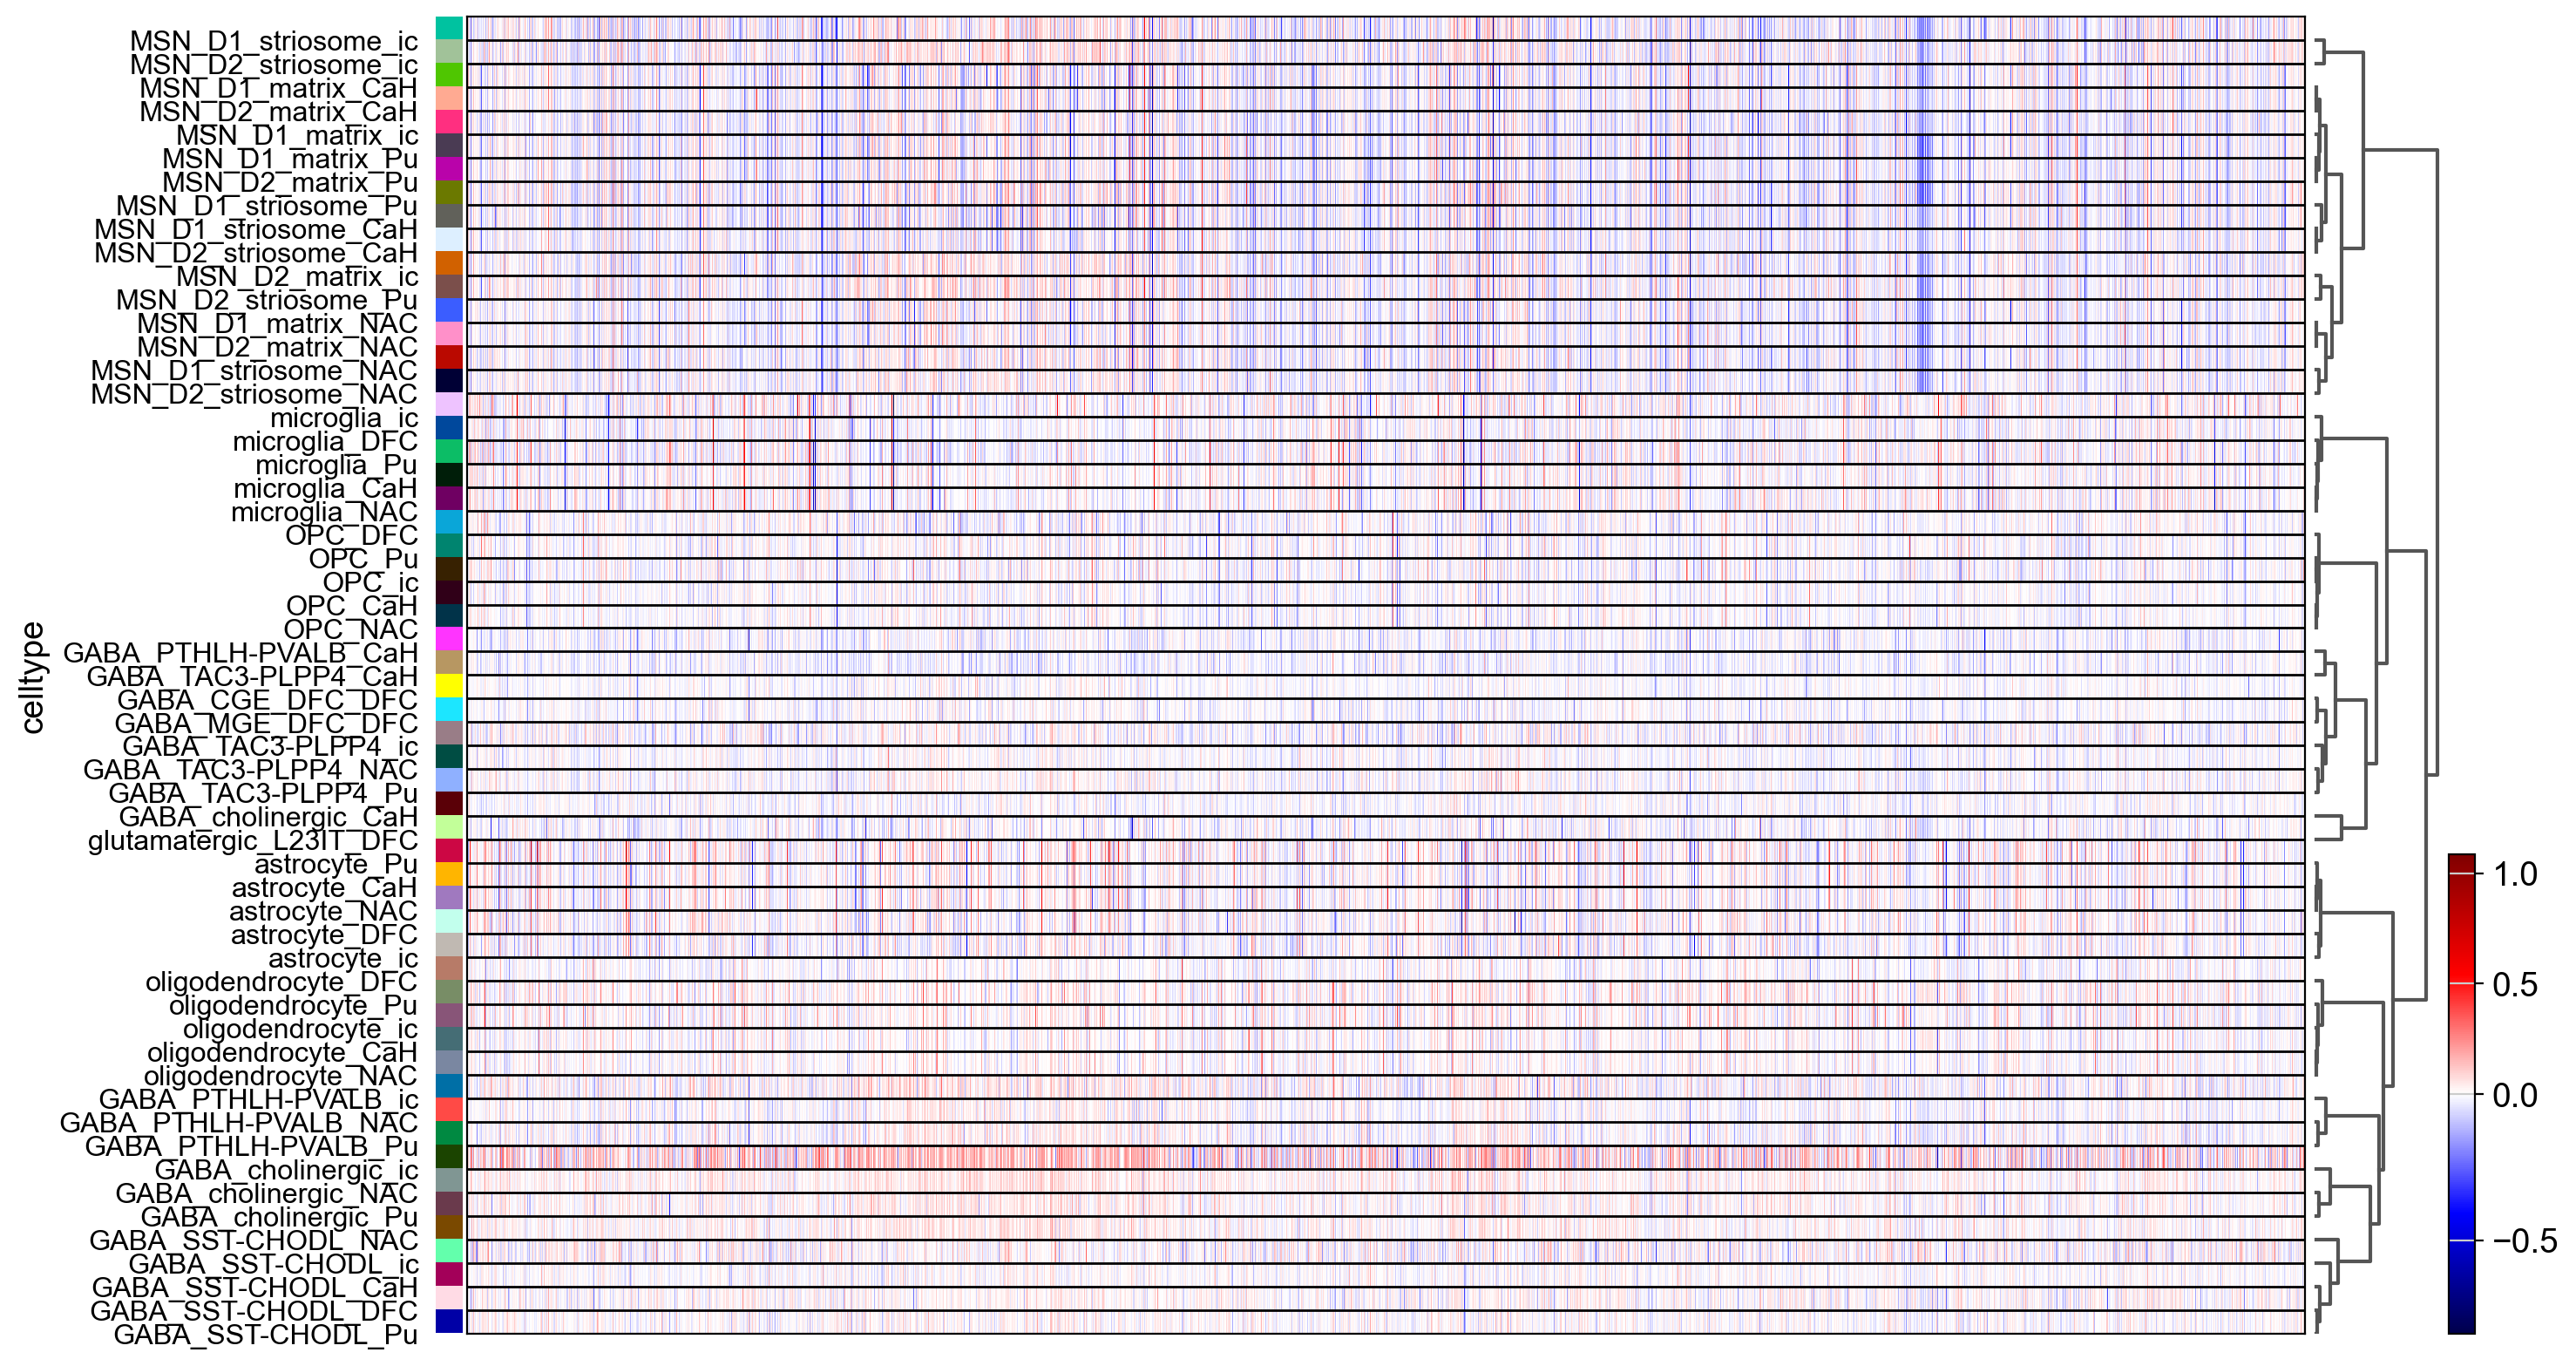

In [13]:
#parse the data
adata=parse_matrix_input(in_file)

# reorders the anndata, adds the plot to the axis.
adata, _ =order_celltypes(adata, num_pcs=10, figsize=(15,10), save=out_cell_ordering_heatmap_file)

/Users/nemesh/miniconda3/envs/dropseq/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/nemesh/miniconda3/envs/dropseq/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/nemesh/miniconda3/envs/dropseq/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/nemesh/miniconda3/envs/dropseq/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/nemesh/miniconda3/envs/dropseq/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/nemesh/miniconda3/envs/dropseq/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invali

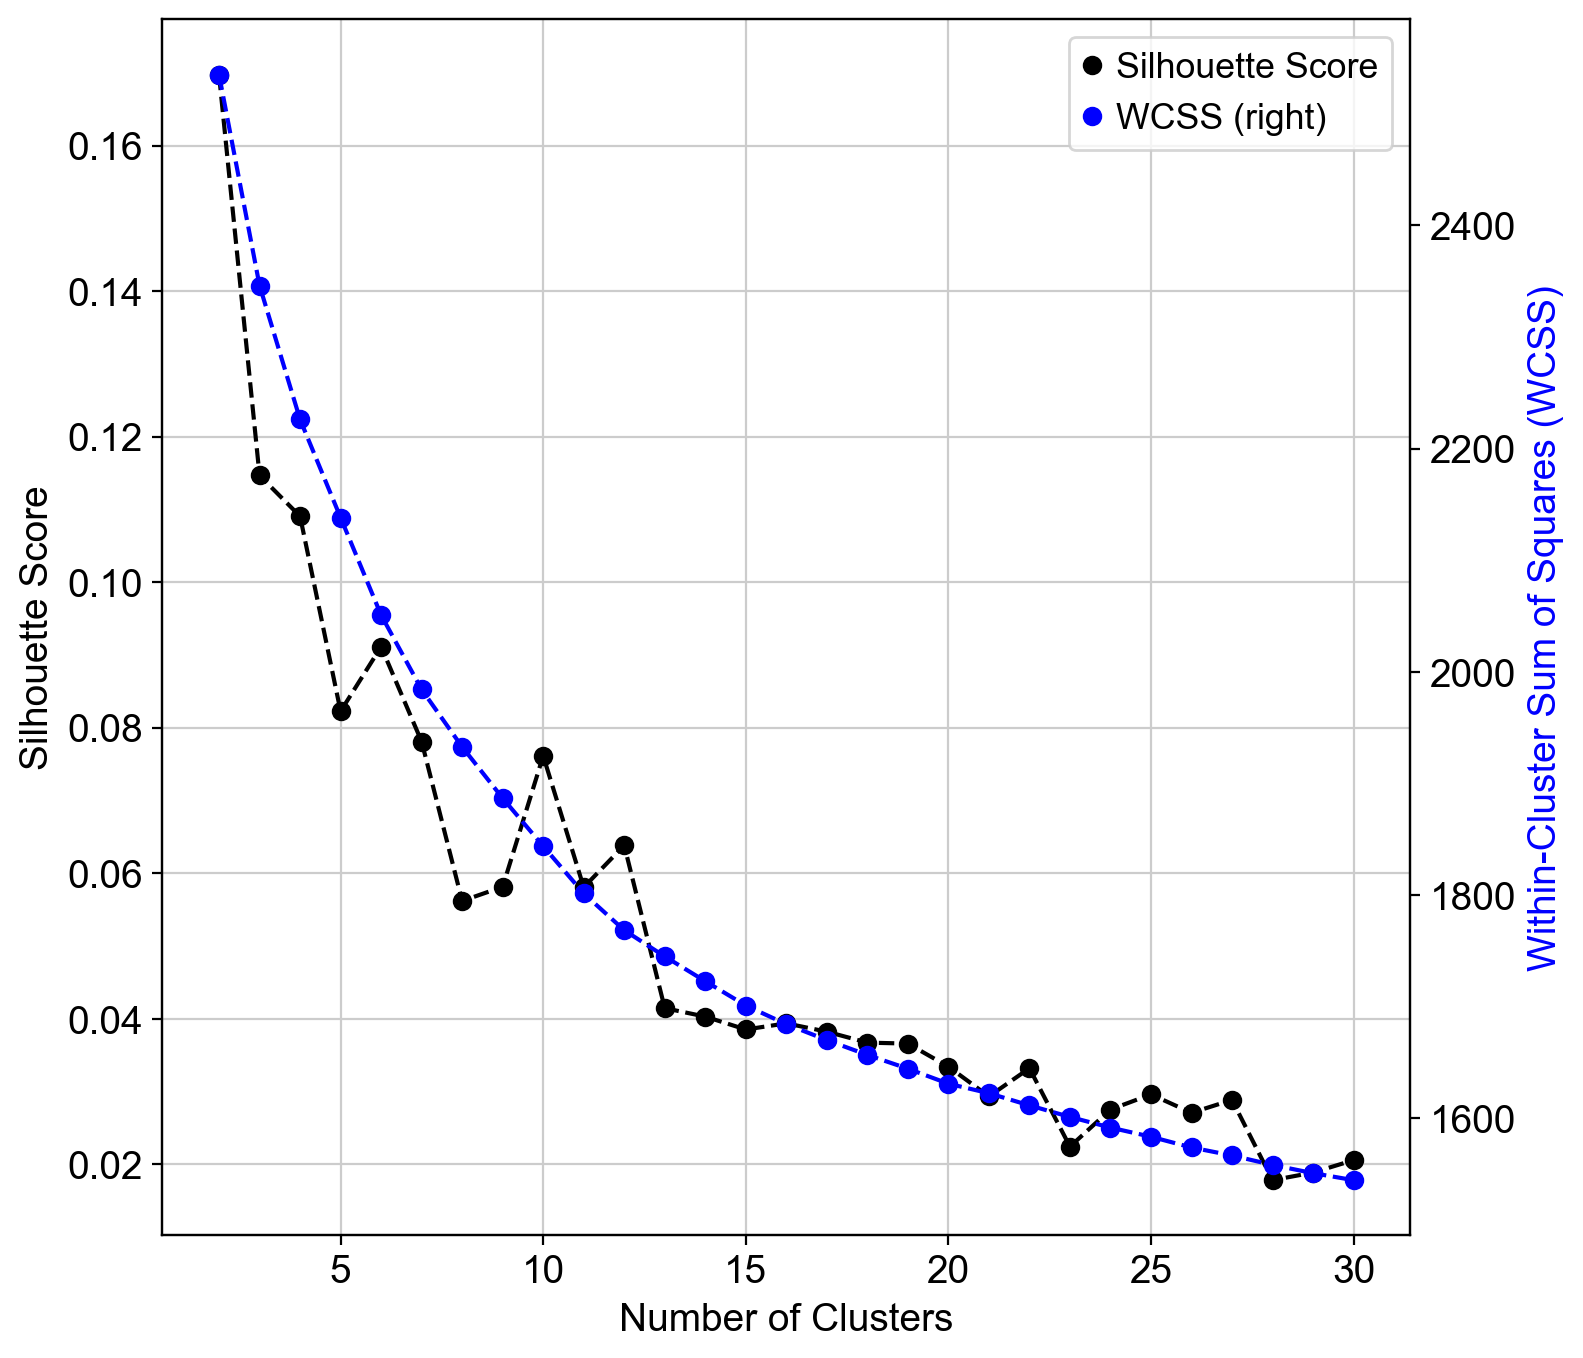

In [14]:
# K-selection plot (axis is returned so it can be composed with other sub-plots if desired.)
ax, k_selection_metrics_df = k_selection_plot(adata, figsize=(8,8), save=out_k_selection_plot_file);
k_selection_metrics_df.to_csv(out_cell_ordering_heatmap_file, sep="\t", index=True, header=True)
plt.show()

In [ ]:
k_selection_metrics_df.head()

In [ ]:
K=12
paths=make_cluster_paths(out_dir, prefix, K)
fig = plot_gene_clustering(adata, k=K, figsize=(18,12), save=paths['heatmap'], out_cluster_labels_filename=paths['labels'])
plt.show()

In [ ]:
K=14
paths=make_cluster_paths(out_dir, prefix, K)
fig = plot_gene_clustering(adata, k=K, figsize=(18,12), save=paths['heatmap'], out_cluster_labels_filename=paths['labels'])
plt.show()

In [ ]:
K=17
paths=make_cluster_paths(out_dir, prefix, K)
fig = plot_gene_clustering(adata, k=K, figsize=(18,12), save=paths['heatmap'], out_cluster_labels_filename=paths['labels'])
plt.show()

# Workflow Demo

In [ ]:
# This runs the whole thing in one shot.
paths = make_base_paths(out_dir, prefix)

run_gene_clustering_workflow(
    in_file=in_file,
    out_dir=out_dir,
    prefix=prefix,
    clust_k=None,
    labels_matrix=paths["labels_matrix"],
    out_pdf=paths["out_pdf"],
    print_pngs=False,
)